## 1.14 Semi-supervised learning

**Semi-supervised learning** is a learning method where some of the training samples are not labeled. The sklearn estimators make use of this unalabeled data to better capture the overall shape of the underyling data distribution, and thus able to better generalize to new samples

These algorithms perform well with very few labeled points and very many unlabeled points

##### Special note: Unlabeled entries in $y$

You must assign an identifier to unlabeled points when training the model with the $fit$ method. The implementations in sklearn use the integer value $(-1)$ as an identifier

Also for string-type labels, the dtype of `y` should be object so it can contain strings and integers

**Also note semi-supervised algorithms need to make certain assumptions about the distribution of the dataset for performance gains**

### 1.14.1 Self Training

The self-training implementation is based on *Yarowsky's algorithm*, where a given supervised classifier functions as a semi-supervised classifier, allowing it to learn from unlabeled data

`SelfTrainingClassifier` can be called with any classifier that implements `predict_proba`; in each iteration the `base_classifier` parameter preddicts labels for the unlabeled samples and adds a subset of these labels to the labeled dataset

The selection criterion include using a `threshold` on prediciton probabilities or by choosing `k_best` samples according to prediction probabilities

###### Example - Effect of varying threshold for self-training
https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_self_training_varying_threshold.html#sphx-glr-auto-examples-semi-supervised-plot-self-training-varying-threshold-py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [3]:
n_splits = 3

X,y = datasets.load_breast_cancer(return_X_y=True)
X,y = shuffle(X,y,random_state=42)

y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

In [4]:
base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

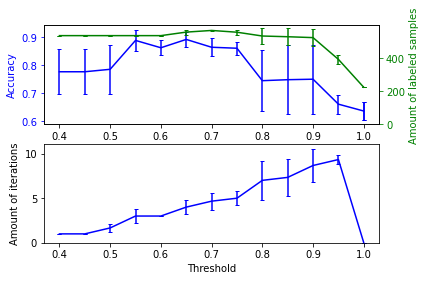

In [5]:
#COPYPASTA
x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for (i, threshold) in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # We need manual cross validation so that we don't treat -1 as a separate
    # class when computing accuracy
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # The amount of labeled samples that at the end of fitting
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()

###### Example - Decision boundary of semi-supervised classifiers versus SVM  on the Iris dataset
https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_versus_svm_iris.html#sphx-glr-auto-examples-semi-supervised-plot-semi-supervised-versus-svm-iris-py

### 1.14.2 Label Propagation

**Label propagation** is the name given to several variations of semi-supervised graph inference algorithms. They are used for classification tasks, and they utilize kernel methods to project data into alternate dimensional spaces

Scikit-learn provides two label propagation methods, `LabelPropagation` and `LabelSpreading`, both of which work  by constructing a *similarity graph* over all item in the input dataset. They differ in modifications to the similarity matrix and also the clamping effect on label distributions

**Clamping** lets the algorithm change the weight on the true ground labeled data

`LabelPropagation` performs hard clamping of input labels, meaning $\alpha=0$. We can relax this to (say) $\alpha=0.2$, meaning we always retain 80% of the original label distribution but the algorithm changes its confidence of the distribution within 20%. It uses the raw similarity matrix constructed from the data with no modifications.

`LabelSpreading` minimizes a loss function that has regularization properties, and it is often more robust to noise. The algorithm iterates on a modified version of the original graph and normalizes the edge weights by computing the normalized graph Laplacian matrix (this procedure is also used in spectral clustering)

###### Example - Label Propagation learning a complex structure
https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-structure-py

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.semi_supervised import LabelSpreading
from sklearn.datasets import make_circles

In [2]:
# generate ring with inner box
n_samples = 200
X, y = make_circles(n_samples=n_samples, shuffle=False)
outer, inner = 0, 1
labels = np.full(n_samples, -1.0)
labels[0] = outer
labels[-1] = inner

In [3]:
#learn with label spreading
label_spread = LabelSpreading(kernel='knn', alpha=0.8)
label_spread.fit(X, labels)

LabelSpreading(alpha=0.8, kernel='knn')

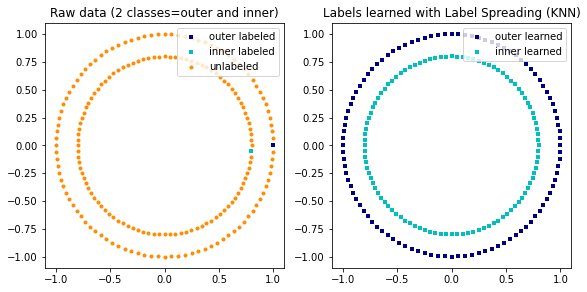

In [4]:
#COPYPASTA
# Plot output labels
output_labels = label_spread.transduction_
plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    X[labels == outer, 0],
    X[labels == outer, 1],
    color="navy",
    marker="s",
    lw=0,
    label="outer labeled",
    s=10,
)
plt.scatter(
    X[labels == inner, 0],
    X[labels == inner, 1],
    color="c",
    marker="s",
    lw=0,
    label="inner labeled",
    s=10,
)
plt.scatter(
    X[labels == -1, 0],
    X[labels == -1, 1],
    color="darkorange",
    marker=".",
    label="unlabeled",
)
plt.legend(scatterpoints=1, shadow=False, loc="upper right")
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]
plt.scatter(
    X[outer_numbers, 0],
    X[outer_numbers, 1],
    color="navy",
    marker="s",
    lw=0,
    s=10,
    label="outer learned",
)
plt.scatter(
    X[inner_numbers, 0],
    X[inner_numbers, 1],
    color="c",
    marker="s",
    lw=0,
    s=10,
    label="inner learned",
)
plt.legend(scatterpoints=1, shadow=False, loc="upper right")
plt.title("Labels learned with Label Spreading (KNN)")

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
plt.show()

###### Example - Label Propagation digits: demonstrating performance
https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-py

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
digits = datasets.load_digits()
rng = np.random.RandomState(2)

indices = np.arange(len(digits.data))
rng.shuffle(indices)

In [8]:
X = digits.data[indices[:340]]
y = digits.target[indices[:340]]
images = digits.images[indices[:340]]

In [9]:
#COPYPASTA
n_total_samples = len(y)
n_labeled_points = 40

indices = np.arange(n_total_samples)

unlabeled_set = indices[n_labeled_points:]

# #############################################################################
# Shuffle everything around
y_train = np.copy(y)
y_train[unlabeled_set] = -1

In [10]:
lp_model = LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(X,y_train)

predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

Label Spreading model: 40 labeled & 300 unlabeled points (340 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      1.00      0.90        37
           2       1.00      0.86      0.92        28
           3       1.00      0.80      0.89        35
           4       0.92      1.00      0.96        24
           5       0.74      0.94      0.83        34
           6       0.89      0.96      0.92        25
           7       0.94      0.89      0.91        35
           8       1.00      0.68      0.81        31
           9       0.81      0.88      0.84        24

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300

Confusion matrix
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  2  1  0  0]
 [ 0  0  0 28  0  5  0  1  0  1]
 [ 0  0  0  0 24  0  0 

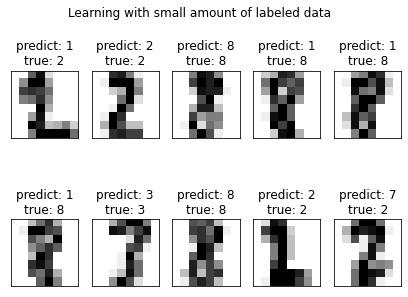

In [11]:
#COPYPASTA
cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print(
    "Label Spreading model: %d labeled & %d unlabeled points (%d total)"
    % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples)
)

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

# #############################################################################
# Calculate uncertainty values for each transduced distribution
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# #############################################################################
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

# #############################################################################
# Plot
f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title(
        "predict: %i\ntrue: %i" % (lp_model.transduction_[image_index], y[image_index])
    )

f.suptitle("Learning with small amount of labeled data")
plt.show()

###### Example - Label Propagation digits active learning
https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-active-learning-py